In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import uniform, randint

In [2]:
# CSVファイルの読み込み
#file_path = "E:\実験\データセット\データセット2/2.次元圧縮後\データセット（視線情報+やさにちチェッカー+意味情報）.csv"
#file_path = "C:/Users/thisi/OneDrive/デスクトップ/データセット（視線情報+やさにちチェッカー+意味情報）.csv"
file_path = "E:\実験\データセット\データセット2/2.次元圧縮後\やさにちチェッカー.csv"
data = pd.read_csv(file_path)

# データのサイズ確認
print(f'Dataset shape: {data.shape}')
print(len(data))

Dataset shape: (416, 11)
416


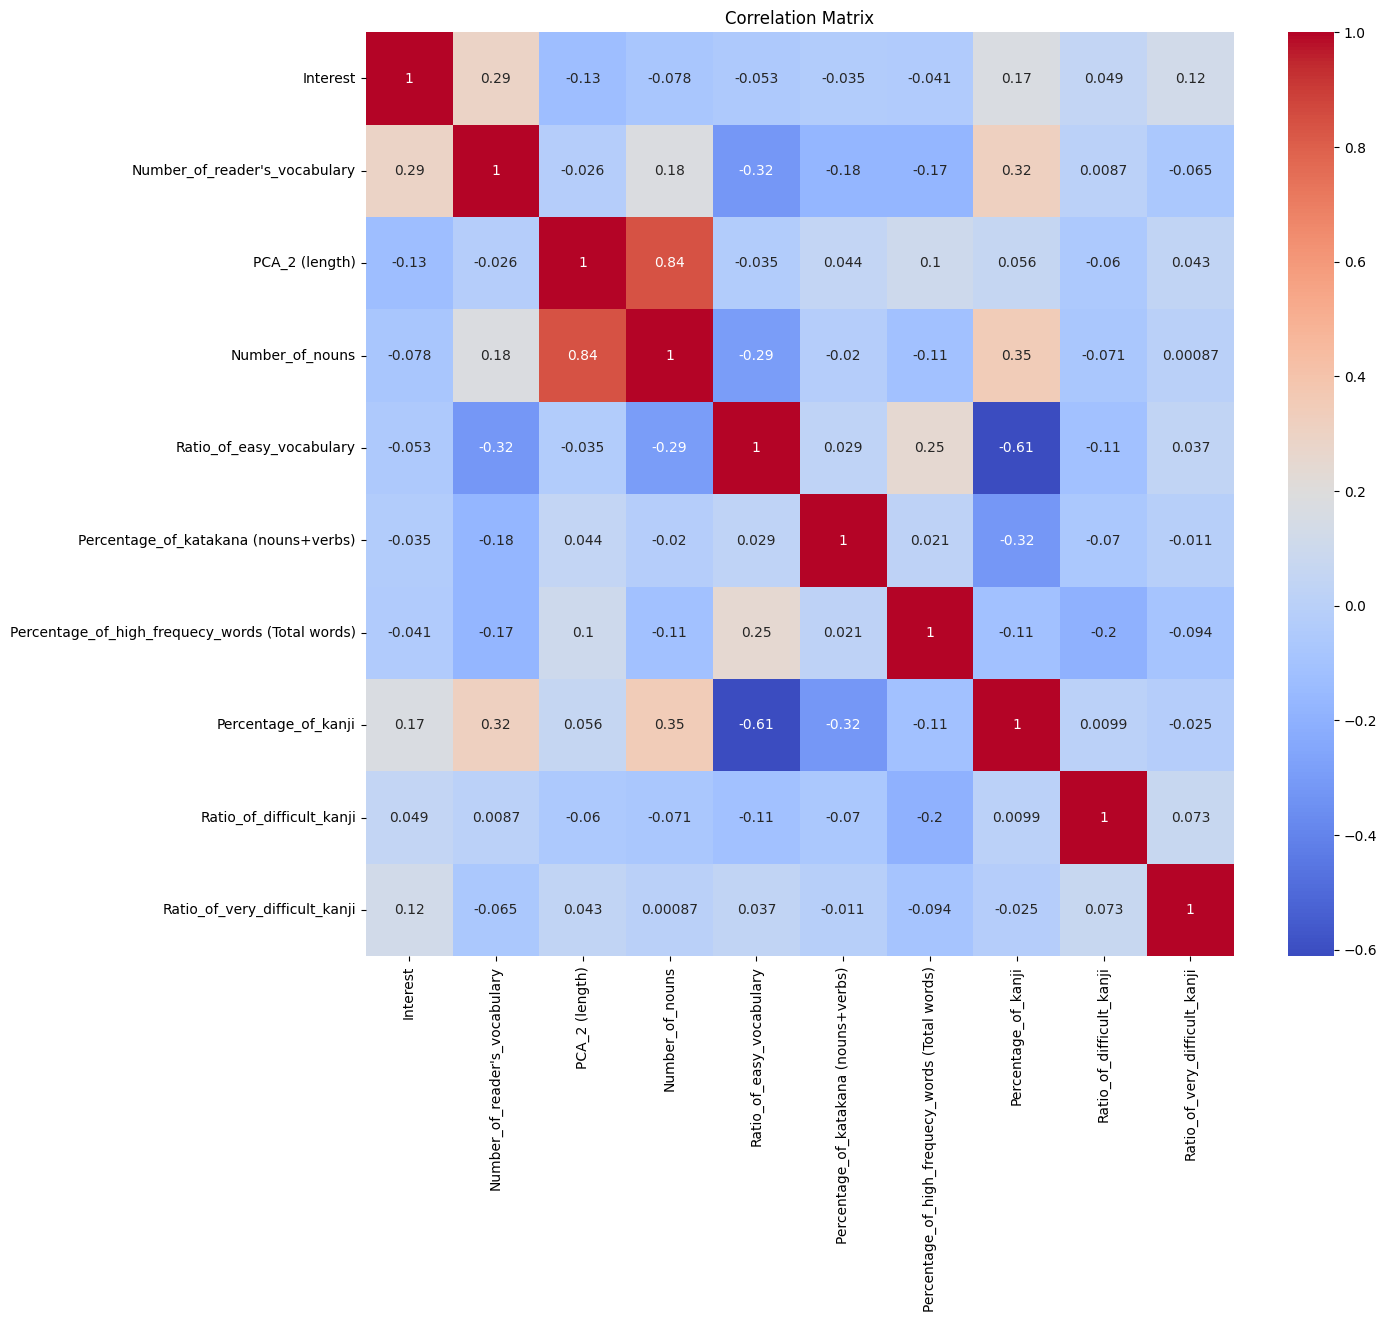

In [3]:
# 説明変数と目的変数の設定
target_variable = 'SD'
X = data.drop(columns=[target_variable])
y = data[target_variable]

# 説明変数間の相関関係を示す画像の出力
plt.figure(figsize=(14, 12))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
param =  {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5],
        'epsilon': [0.01, 0.05, 0.1, 0.5, 1, 5],
        'kernel': ['rbf'],
        'gamma':[0.01, 0.05, 0.1, 0.5, 1, 5, 'auto','scale']
    }


In [5]:
# 特徴量の数を変えてSFSを実施し、最も良い精度を持つモデルを選択
best_score = float('inf')
best_num_features = 0
best_selector = None

# 特徴量の総数を取得
total_features = X.shape[1]

for num_features in range(1, total_features):  # total_features - 1 まで
        estimator = SVR(kernel="rbf")
        selector = SequentialFeatureSelector(
            estimator, 
            n_features_to_select=num_features, 
            direction='forward'
        )
        
        # X_scaledがまだ定義されていない場合は、ここで定義する
        X_scaled = scaler.fit_transform(X)
        
        selector = selector.fit(X_scaled, y)
        
        X_selected = X.iloc[:, selector.get_support()]
        X_selected_scaled = scaler.fit_transform(X_selected)
        
        # GridSearchCVによるハイパーパラメータの調整
        param_grid = param
        grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=10, scoring='neg_mean_squared_error')
        grid_search.fit(X_selected_scaled, y)
        
        # 最適なハイパーパラメータでのモデルの評価
        best_svr = grid_search.best_estimator_
        kfold = KFold(n_splits=len(data), shuffle=True, random_state=42)
        cv_results = cross_val_score(best_svr, X_selected_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
        mean_score = -cv_results.mean()
        
        if mean_score < best_score:
            best_score = mean_score
            best_num_features = num_features
            best_selector = selector

# 最適な特徴量数で再構築
X_selected = X.iloc[:, best_selector.get_support()]
X_selected_scaled = scaler.fit_transform(X_selected)
print(f'Best number of features: {best_num_features}')
print(f'Selected features: {X.columns[best_selector.get_support()].tolist()}')
print(f'Best mean squared error: {best_score}')

Best number of features: 9
Selected features: ['Interest', 'PCA_2 (length)', 'Number_of_nouns', 'Ratio_of_easy_vocabulary', 'Percentage_of_katakana (nouns+verbs)', 'Percentage_of_high_frequecy_words (Total words)', 'Percentage_of_kanji', 'Ratio_of_difficult_kanji', 'Ratio_of_very_difficult_kanji']
Best mean squared error: 0.8314602045175097


In [7]:
# GridSearchCVによるハイパーパラメータの調整
"""param_grid = {
        'C': [0.1, 1, 3, 5, 10, 20, 30],
        'epsilon': [0.01, 0.1, 1, 10, 30],
        'kernel': ['rbf'],
        'gamma':[0.1, 1, 5, 10, 100, 'auto','scale']
}"""

param_grid = param
grid_search = GridSearchCV(SVR(), param_grid, cv=10, scoring='neg_mean_squared_error')
#grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_selected_scaled, y)

# 最適なハイパーパラメータの表示
print(f'Best parameters found: {grid_search.best_params_}')

Best parameters found: {'C': 5, 'epsilon': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}


In [9]:
# 最適なパラメータでのモデルの再構築
best_svr = grid_search.best_estimator_
#best_svr = random_search.best_estimator_

# k分割交差検定の実施
kfold = KFold(n_splits=len(data), shuffle=True, random_state=42)
cv_results = cross_val_score(best_svr, X_selected_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
cv_results2 = cross_val_score(best_svr, X_selected_scaled, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Cross-Validation MSE: {-cv_results.mean()}')
print(f'Cross-Validation MAE: {-cv_results2.mean()}')

Cross-Validation MSE: 0.8314602045175097
Cross-Validation MAE: 0.6871627958937865


In [10]:
# モデルの評価指標の出力
best_svr.fit(X_selected_scaled, y)
y_pred = best_svr.predict(X_selected_scaled)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

MSE: 0.7683219138673315
R2 Score: 0.23167808612541518
MAE: 0.6575163744367706
MAPE: 2.309361444168507
RMSE: 0.8765397388979758


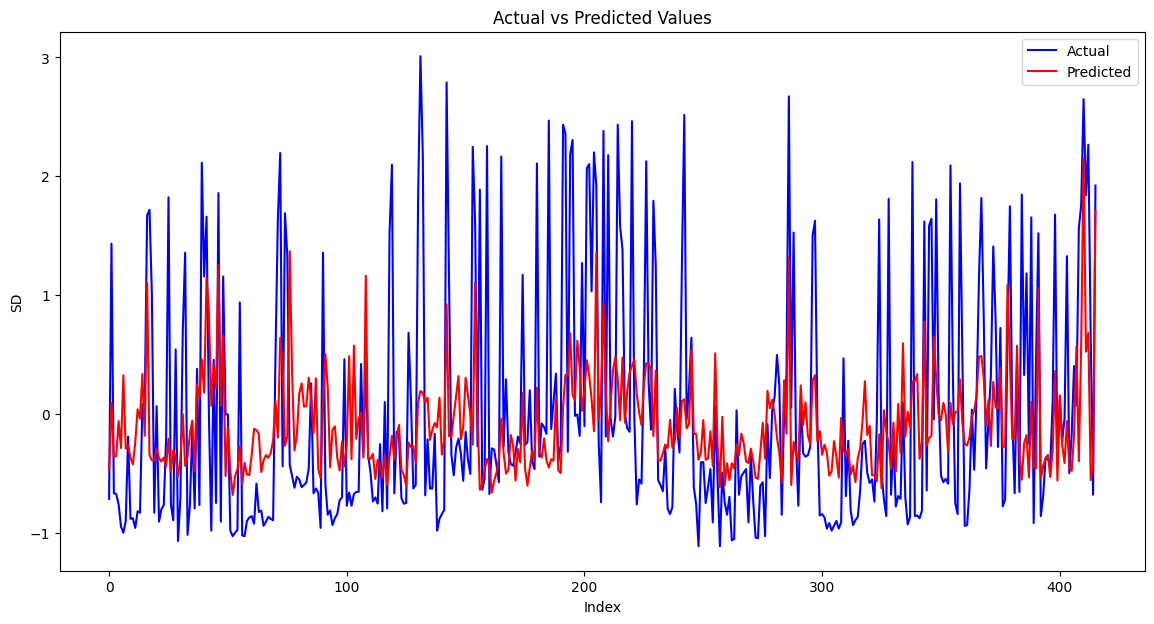

In [11]:
# 全データセットに対して予測を行い、実測値と予測値の誤差を出力
errors = y - y_pred
results = pd.DataFrame({'Actual': y, 'Predicted': y_pred, 'Error': errors})
results.to_csv('SVR軽量版_やさにちチェッカー.csv', index=False)

# 実測値と予測値の時系列プロットの出力
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y.index, y_pred, label='Predicted', color='red')
plt.xlabel('Index')
plt.ylabel(target_variable)
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

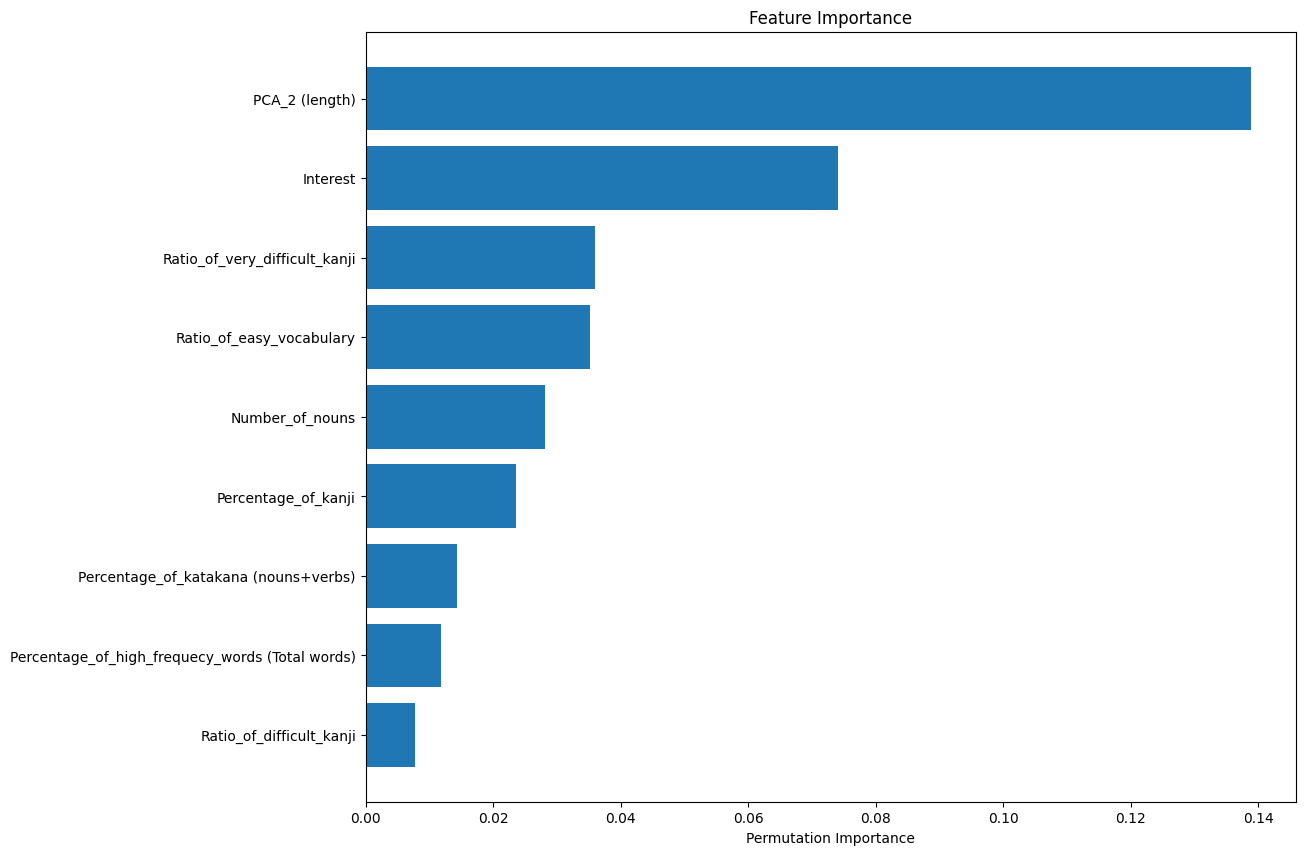

In [12]:
# 特徴量の重要度を示す画像の出力
perm_importance = permutation_importance(best_svr, X_selected_scaled, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(12, 10))
plt.barh(X.columns[best_selector.support_][sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

In [13]:
print(perm_importance.importances_mean[sorted_idx])

[0.0077176  0.01187844 0.01430784 0.02351954 0.02820001 0.03517885
 0.0358964  0.07403713 0.13896698]
